# Basic demo for FASHN VTON v1.5

FASHN VTON v1.5: Efficient Maskless Virtual Try-On in Pixel Space

GitHub: https://github.com/fashn-AI/fashn-vton-1.5

## Installation

In [1]:
!git clone https://github.com/fashn-AI/fashn-vton-1.5
%cd fashn-vton-1.5

fatal: destination path 'fashn-vton-1.5' already exists and is not an empty directory.
/content/fashn-vton-1.5


In [2]:
!pip install -e .

Obtaining file:///content/fashn-vton-1.5
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for fashn-vton (pyproject.toml) ... done
  Created wheel for fashn-vton: filename=fashn_vton-1.5.0-0.editable-py3-none-any.whl size=5771 sha256=690018b8dfa894c2b0f26bf8ce49ac76fb1644da36a11586353c39ece8788a66
  Stored in directory: /tmp/pip-ephem-wheel-cache-e1f5f62s/wheels/83/85/d4/003a2789df48fea4fd69c5093b73b4495d75e045a364d41756
Successfully built fashn-vton
  Attempting uninstall: fashn-vton
    Found existing installation: fashn-vton 1.5.0
    Uninstalling fashn-vton-1.5.0:
      Successfully uninstalled fashn-vton-1.5.0


In [3]:
!python scripts/download_weights.py --weights-dir ./weights



  Saved to: /content/fashn-vton-1.5/weights/model.safetensors

  Saved to: /content/fashn-vton-1.5/weights/dwpose/yolox_l.onnx
  Saved to: /content/fashn-vton-1.5/weights/dwpose/dw-ll_ucoco_384.onnx

Loading weights: 100% 930/930 [00:01<00:00, 714.92it/s, Materializing param=segformer.encoder.patch_embeddings.3.proj.weight]
  Cached in HuggingFace hub cache

Download complete!

Weights directory structure:
    /content/fashn-vton-1.5/weights/
    ├── model.safetensors
    └── dwpose/
        ├── yolox_l.onnx
        └── dw-ll_ucoco_384.onnx

Usage:
    from fashn_vton import TryOnPipeline
    pipeline = TryOnPipeline(weights_dir="/content/fashn-vton-1.5/weights")



## Functionality test

In [8]:
from IPython.display import display
from PIL import Image
from fashn_vton import TryOnPipeline
import matplotlib.pyplot as plt

In [10]:
# Initialize pipeline (automatically uses GPU if available)
pipeline = TryOnPipeline(weights_dir="./weights")

# Load images
person = Image.open("examples/data/model.webp").convert("RGB")
garment = Image.open("examples/data/garment.webp").convert("RGB")

# Run inference
result = pipeline(
    person_image=person,
    garment_image=garment,
    category="tops",  # "tops" | "bottoms" | "one-pieces"
)

TryOnPipeline - INFO - Using device: cuda
TryOnPipeline - INFO - Using dtype: torch.bfloat16
TryOnPipeline - INFO - Loading TryOnModel from /content/fashn-vton-1.5/weights/model.safetensors
TryOnPipeline - INFO - TryOnModel loaded
TryOnPipeline - INFO - Loading DWPose from /content/fashn-vton-1.5/weights/dwpose
TryOnPipeline - INFO - DWPose loaded
TryOnPipeline - INFO - Loading FashnHumanParser


Loading weights:   0%|          | 0/930 [00:00<?, ?it/s]

TryOnPipeline - INFO - FashnHumanParser loaded
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


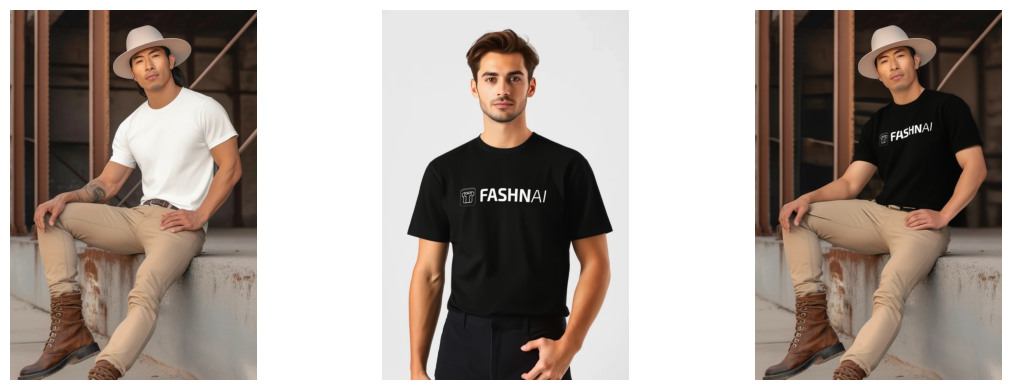

In [14]:
imgs = [person, garment, result.images[0]]
plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Gradio Demo

In [17]:
import gradio as gr
from PIL import Image
import torch

def run_vton(person_img, garment_img, category):
    person_img = Image.fromarray(person_img)
    garment_img = Image.fromarray(garment_img)
    result = pipeline(
        person_image=person_img,
        garment_image=garment_img,
        category=category,
    )
    return result.images[0]

demo = gr.Interface(
    fn=run_vton,
    inputs=[
        gr.Image(type="numpy", label="Person"),
        gr.Image(type="numpy", label="Garment"),
        gr.Radio(
            choices=["tops", "bottoms", "one-pieces"],
            value="tops",
            label="Category",
        ),
    ],
    outputs=gr.Image(type="pil", label="Result"),
    title="Virtual Try-On Demo",
    description="Upload a person image and a garment image to generate a try-on result.",
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://85c2878a2478c10b2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Extending for multiple people

In [18]:
import requests
from io import BytesIO

In [25]:
url = "https://thumbs.dreamstime.com/b/full-length-portrait-group-young-men-wearing-jeans-looking-camera-smiling-35328409.jpg"

resp = requests.get(url, timeout=30)
resp.raise_for_status()

people = Image.open(BytesIO(resp.content)).convert("RGB")
people.save("examples/data/people.png")

In [22]:
result = pipeline(
    person_image=people,
    garment_image=garment,
    category="tops",  # "tops" | "bottoms" | "one-pieces"
)

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


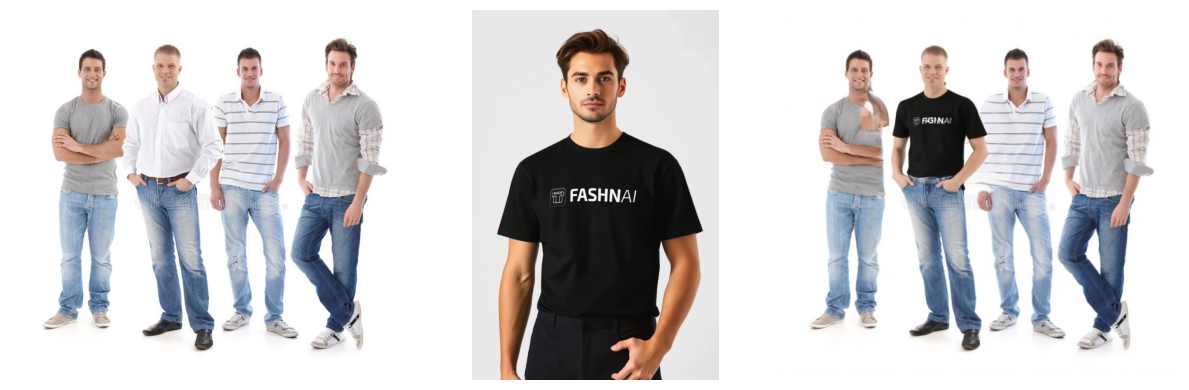

In [23]:
imgs = [people, garment, result.images[0]]
plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Baseline approach

As you can see from the above result, attempting to run this model for multiple subjects leads to a glitched output.

A simple appraoch would be to segment the original image by the people, apply to each individual, and then re-combine. For the segementation, we will use Ultralytics YOLO https://github.com/ultralytics/ultralytics.

In [24]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.5 MB/s eta 0:00:00


In [30]:
from ultralytics import YOLO
import cv2
import numpy as np

In [72]:
# Load a model
model = YOLO("yolo26n-seg.pt")

# Predict with the model
results = model("examples/data/people.png")  # predict on an image


image 1/1 /content/fashn-vton-1.5/examples/data/people.png: 576x640 4 persons, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


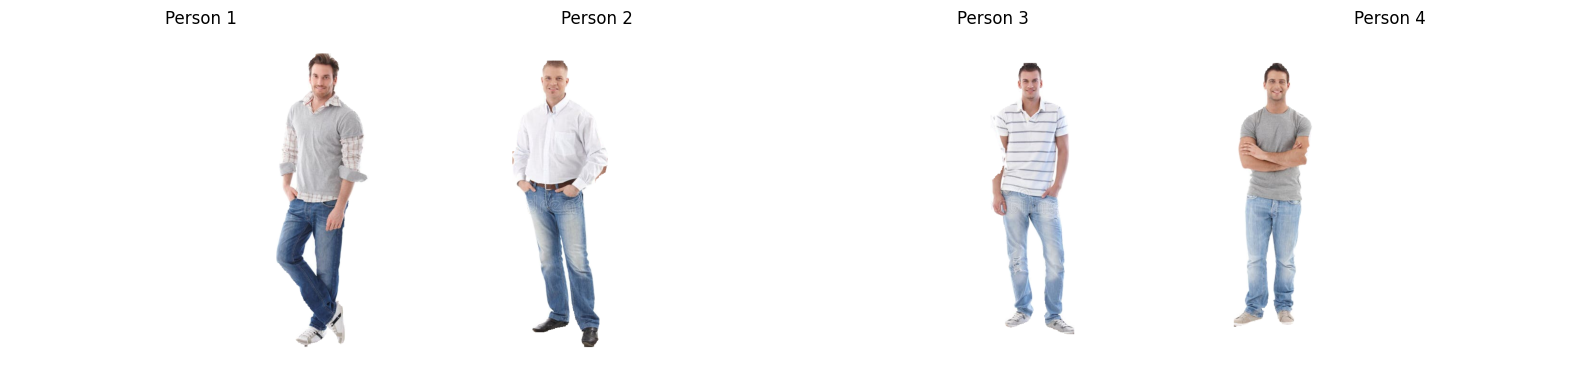

In [73]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

result = results[0]
masks = result.masks.data.cpu().numpy()  # (N, H, W)
masks = [cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST).astype(bool)
          for mask in masks]
H, W = img.shape[:2]

people = []
for mask in masks:
    cutout = img.copy()
    cutout[~mask] = 255
    img_pil = Image.fromarray(cutout)
    people.append(img_pil)

# Plot side by side
plt.figure(figsize=(4 * len(people), 4))
for i, person in enumerate(people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.title(f"Person {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [74]:
vton_people = []
for person in people:
  result = pipeline(
      person_image=person,
      garment_image=garment,
      category="tops",  # "tops" | "bottoms" | "one-pieces"
  )
  vton_people.append(result.images[0])

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


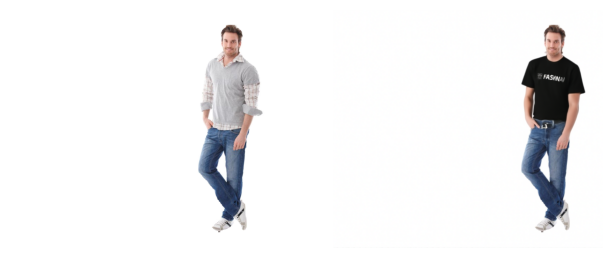

In [68]:
plt.figure(figsize=(16, 8))
for i, person in enumerate([people[0], vton_people[0]], 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.axis("off")

In [75]:
vton_masks = []
for people in vton_people:
  results = model(np.array(people))
  result = results[0]
  mask = result.masks.data.cpu().numpy()[0]  # (N, H, W)
  vton_masks.append(cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST).astype(bool))


0: 576x640 1 person, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


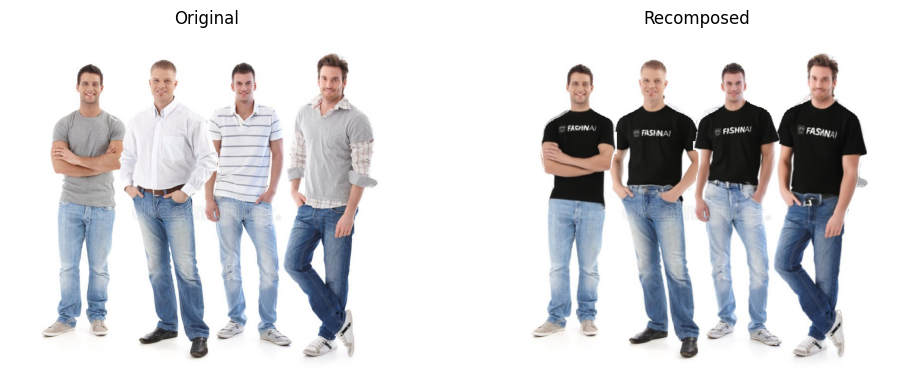

In [78]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Start with a blank canvas (black background)
recomposed = img.copy()

for mask, vton_mask, img_pil in zip(masks, vton_masks, vton_people):
    vton_img = np.array(img_pil.resize((W, H)))
    # recomposed[mask] = 255
    recomposed[vton_mask] = vton_img[vton_mask]

# Show side by side: original vs recomposed
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recomposed)
plt.title("Recomposed")
plt.axis("off")

plt.tight_layout()
plt.show()

Looks ok, but there are a lot of cropping artifacts, especially where the people cover each other. Another peoplem in composing the images is that the shape and size of the clothes now differs from the original image.

Ordinarily, this is something that FASHN-VTON is good at handling, so using precise masks may not be the best solution.